In [ ]:
### https://pennylane.ai/qml/demos/tutorial_backprop.html#sphx-glr-demos-tutorial-backprop-py

In [1]:
import pennylane as qml

from pennylane import numpy as np
from matplotlib import pyplot as plt


np.random.seed(42)

dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")

    qml.RX(params[3], wires=0)
    qml.RY(params[4], wires=1)
    qml.RZ(params[5], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")
    
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

In [2]:
# initial parameters
params = np.random.random([6], requires_grad=True)

print("Parameters:", params)
print("Expectation value:", circuit(params))

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation value: -0.11971365706871569


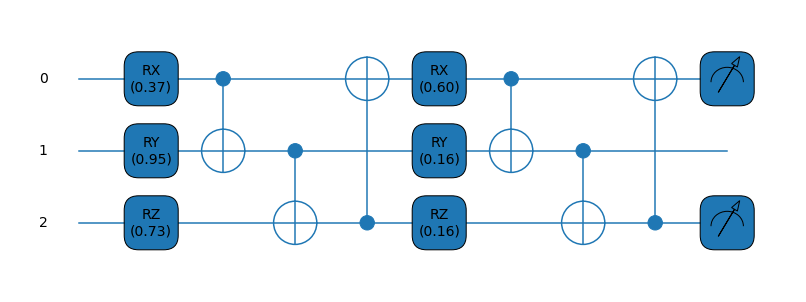

In [3]:
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [4]:
# Compute the gradient of the i-th parameter using the parameter-shift rule

def parameter_shift_term(qnode, params, i):
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(circuit, params, 0))


# Compute the gradient with respect to all parameters

def parameter_shift(qnode, params):
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode, params, i)

    return gradients


# Run

print(parameter_shift(circuit, params))

-0.0651887722495812
[-6.51887722e-02 -2.72891905e-02 -2.77555756e-17 -9.33934621e-02
 -7.61067572e-01  0.00000000e+00]


In [5]:
# PennyLane built-in general gradient

grad_function = qml.grad(circuit)

print(grad_function(params))


# PennyLane built-in parameter-shift gradient

print(qml.gradients.param_shift(circuit)(params))

[-6.51887722e-02 -2.72891905e-02 -4.10464615e-17 -9.33934621e-02
 -7.61067572e-01  5.86901964e-19]
[-6.51887722e-02 -2.72891905e-02 -4.10464615e-17 -9.33934621e-02
 -7.61067572e-01  5.86901964e-19]


In [6]:
# Larger circuit

dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    
    qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

# initialize circuit parameters

param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=15)
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)

print(params.size)
print(circuit(params))

180
0.8947771876917714


In [7]:
# Forward pass

import timeit

reps = 3
num = 10

times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)

forward_time = min(times) / num

print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.020064342021942138 sec per loop


In [8]:
# Compute the full gradient vector

# create the gradient function
grad_fn = qml.grad(circuit)

times = timeit.repeat("grad_fn(params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num

print(f"Gradient computation (best of {reps}): {backward_time} sec per loop")

Gradient computation (best of 3): 5.69037129022181 sec per loop
